## Image transformation
Given an image, or a frame of a video stream, we want preserve only the area around the marker (aruco or other marker), rotating and cropping the image. This can be useful for restricting the area for successive search of elements like switches or plugs.

In [1]:
# Import libraries once
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)

In [3]:
def show_two_imgs(img1, text1, img2, text2):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    if img1.shape[-1] == 3:
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img1, cmap = 'gray', vmin=0, vmax=255)
    plt.title(text1)

    plt.subplot(1,2,2)
    if img2.shape[-1] == 3:
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img2, cmap = 'gray', vmin=0, vmax=255)
    plt.title(text2)
    plt.show()

Define some rotation function. "rotate_image" rotates the image but do not change the original shape, so if the rotation is 90°, the resulting image is cropped square with big black borders. The second function is the implementation of the function in ***imutils*** library; it rotate the image and resize to minimize black borders around.

In [2]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

### Handle the rotation
First try to rotate the image according to the top of the marker. We need the top-left and top-right corner of the marker, then we can compute the inclination of the ideal segment between the points.\
The same procedure can be applied with round markers, considering the virtual line joining the two centers, assuming the markers are placed parallel wrt the floor.\
This is not a restrictive assumption for our goal. Before the competition judges provide to each team a fac-simile of the panel. This allow us to refine the algorithms for the search.

Found 1 markers.
Rect with angle: 282.45824644000487
Dims: [1280  622]
Corner of the marker: [[312 556]
 [293 642]
 [207 623]
 [226 536]]


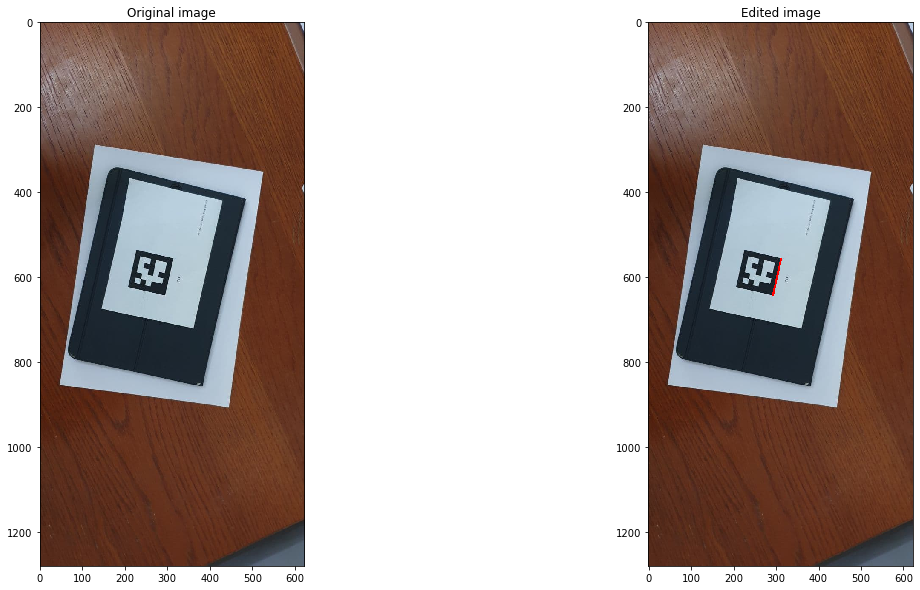

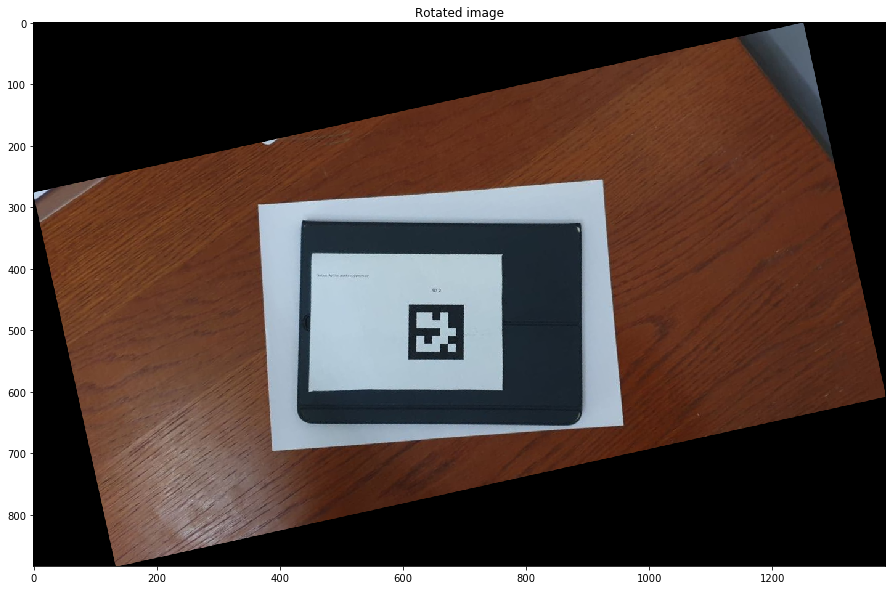

In [4]:
# Import marker cognition functions analyzed in aruco-recognition.ipynb
%run aruco-function-definition.ipynb

# Read the image and get all the aruco corners
imgRect, idsR, cornersR = findAruco("test-imgs/double-rectangle.jpg", ARUCO_DICT, ARUCO_PARAMETERS)
imgToDraw = np.copy(imgRect) # Make a copy for drawing

markers_rects = findRectangles(imgRect, idsR, cornersR)
# markers_rects contains an array of contours for each aruco

cornersR = cornersR[0].astype(int)

print("Found {} markers.".format(len(idsR)))

#imgRectMin = np.copy(imgRect) # Only smallest one
min_contours = [] # store the min contour of each marker found in image
if len(markers_rects) > 0: 
    for mrk in markers_rects: # for every marker in image...
        areas = np.array(list(map(cv2.contourArea, mrk))) # compute the area of each contour
        
        min_area_n = np.argmin(areas) # find array num of the smallest area
        min_contours.append(mrk[min_area_n])
        #cv2.drawContours(imgRectMin, [rect[min_area_n]], -1, (0,255,0), 2) # draw the contour of only the smallest
    # Now we have the correct contour for each marker
    # We need to find the orientation
    
    # For visualizing the problem, draw a line between two top corners of the marker
    # this line should be orizontal at the end of the program
    cv2.line(imgToDraw, tuple(cornersR[0][0].ravel()), (tuple(cornersR[0][1].ravel())), (0, 0, 255), thickness=3, lineType=8)
    
    # Get the orientation on the line as angle
    angle = np.arctan2(cornersR[0][0][1] - cornersR[0][1][1], cornersR[0][0][0] - cornersR[0][1][0]);
    if angle < 0:
        angle += 2 * np.pi
    angle_deg = angle * 180 / np.pi
    print("Rect with angle:", angle_deg)
    
    imgOriz = rotate_bound(imgRect, 180-angle_deg)
    print("Dims:", np.flip(imgRect.shape[1::-1]))
    #maxx, maxy = np.max(a, axis=0)
else:
    print("No containers found!")
    
print("Corner of the marker:", cornersR[0])
show_two_imgs(imgRect, "Original image", imgToDraw, "Edited image")

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(imgOriz, cv2.COLOR_BGR2RGB))
plt.title("Rotated image")
plt.show()

We analyzed a very special case. We are in fact considering that only one marker is present.\
We now improve the code, add support of multiple markers and also crop the image around the closest rectangle.

For convenience we declared a function that we recall later:

In [5]:
def cut_markers_area(imgPath):
    # Read the image and get all the aruco corners
    imgRect, idsR, cornersR = findAruco(imgPath, ARUCO_DICT, ARUCO_PARAMETERS)
    imgToDraw = np.copy(imgRect) # Make a copy for drawing

    markers_rects = findRectangles(imgRect, idsR, cornersR)
    # markers_rects contains an array of contours for each aruco

    cornersR = cornersR[0].astype(int)

    print("Found {} markers.".format(len(idsR)))

    #imgRectMin = np.copy(imgRect) # Only smallest one
    img_mrk = [] # store a cutted copy of the original image for each marker found
    if len(markers_rects) == 0:
        return [] # No marker found in image
    
    i = 0
    for mrk in markers_rects: # for every marker in image...
        areas = np.array(list(map(cv2.contourArea, mrk))) # compute the area of each contour
        
        min_area_n = np.argmin(areas) # find array num of the smallest area
        print(mrk[min_area_n].shape)
        maxx, maxy = np.max(mrk[min_area_n].reshape((mrk[min_area_n].shape[0], 2)), axis=0) + 10
        minx, miny = np.min(mrk[min_area_n].reshape((mrk[min_area_n].shape[0], 2)), axis=0) - 10
        print("x:", minx, maxx)
        _img_rot = np.copy(imgRect) #np.copy(imgRect[miny:maxy, minx:maxx, :])
        
        angle = np.arctan2(cornersR[i][0][1] - cornersR[i][1][1], cornersR[i][0][0] - cornersR[i][1][0]);
        if angle < 0:
            angle += 2 * np.pi
        angle_deg = angle * 180 / np.pi
    
        #_img_rot = rotate_image(_img_rot, 180+angle_deg)
        _image_center = tuple(np.array(_img_rot.shape[1::-1]) / 2)
        _rot_mat = cv2.getRotationMatrix2D(_image_center, angle, 1.0)
        _img_rot = cv2.warpAffine(_img_rot, _rot_mat, _img_rot.shape[1::-1], flags=cv2.INTER_LINEAR)
        _extrema = cv2.perspectiveTransform(np.array([maxx,maxy,minx,miny]), _rot_mat)
                
        img_mrk.append(_img_rot[_extrema[0][1]:_extrema[1][1], _extrema[0][0]:_extrema[1][0], :])
        
        i+=1
    return img_mrk

In [59]:
rois = cut_markers_area("test-imgs/double-rectangle.jpg")

for img in rois:
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Rotated image")
    plt.show()

Found 1 markers.
(472, 1, 2)
x: 135 437


error: OpenCV(4.4.0) /tmp/pip-req-build-4gvd3asq/opencv/modules/core/src/matmul.dispatch.cpp:531: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'


In [24]:
a = np.array([[188,24], [200,10], [88,290]])
maxx, maxy = np.max(a, axis=0)
print(maxx, maxy)

200 290


In [33]:
a = np.ones((4, 1, 2))
print(a)
b = a.reshape((4, 2))
print(b)

[[[1. 1.]]

 [[1. 1.]]

 [[1. 1.]]

 [[1. 1.]]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
